In [6]:
import pandas as pd
import math
import numpy as np
import datetime

import matplotlib.pyplot as plt

import time

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from sklearn.metrics import r2_score

# from genetic_selection import GeneticSelectionCV

## Dataset Description

This dataset contains some of technical indicators (The value of period is taken as 14), some of exchange rates (based on usd), financial indexes of America (Dow_Jones, NASDAQ, S&P_500) and the last one is daily Google Trends data. Google Trends is a tool to provide to know number of searches for a word (or a term) on the internet.

## Methodology
Our goal is to predicting stock movement rather than stock prices. We can do this in two ways:

First way is apply a regression method in our data and predict a time series that try to mimic target values. Then we compare their daily movements between our predicted signal and real signal.

Secondly, the method can be done with classification or regression. This time our target is price movement and it is a boolean value. If it is true, close price's of company will increase tomorrow. If it is false, it will decrease. If you use a classifier there is no problem. Output is always a boolean value but if you do with the regression, output value is a number between 0 and 1. In this case you can round your values to 0 or 1 and they will be your predicted class values.

And then we will do optimization or feature selection to some of our models for improve our accuracies.

In [7]:
def readDataFromCSV(file_path):
    data = pd.read_csv(file_path)
    data.reset_index()
    data = data.set_index("Date")
    data.index = pd.to_datetime(data.index)
    return data

In [8]:
def readDataAndWrite(stock_code, file_path):
    ticker = yf.Ticker(stock_code)
    data= ticker.history(period= "max")
    data.to_csv(r""+ file_path)

In [9]:
mydata = readDataFromCSV('/content/mydata.csv')

In [10]:
mydata.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Gain', 'Loss', 'Avg_Gain', 'Avg_Loss', 'RSI', 'SMA', 'EMA', 'MACD',
       'Bollinger_Upper', 'Bollinger_Lower', 'ROC', 'PVT', 'Usd_Eur_Close',
       'Usd_Chf_Close', 'Usd_Gbp_Close', 'Usd_Jpy_Close', 'Usd_Cad_Close',
       'Usd_Inf_Close', 'Usd_Rub_Close', 'Usd_Try_Close', 'IRX_Close',
       'JPM_Close', 'BAC_Close', 'Citigroup_Close', 'WFC_Close',
       'NASDAQ_Close', 'SP_500_Close', 'Dow_Jones_Close'],
      dtype='object')

In [11]:
mydata

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Gain,Loss,Avg_Gain,...,Usd_Rub_Close,Usd_Try_Close,IRX_Close,JPM_Close,BAC_Close,Citigroup_Close,WFC_Close,NASDAQ_Close,SP_500_Close,Dow_Jones_Close
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,44.95,45.44,44.21,44.52,10446500,0,0.0,0.23,0.00,0.572143,...,27.7100,1.3440,2.204,26.45,34.03,440.71,19.30,2152.149902,1202.079956,10729.429688
2005-01-04,42.67,43.26,41.50,42.14,19418500,0,0.0,0.00,2.38,0.528571,...,27.7100,1.3510,2.292,26.18,33.56,436.96,19.31,2107.860107,1188.050049,10630.780273
2005-01-05,41.57,42.76,41.56,41.77,8354200,0,0.0,0.00,0.37,0.488571,...,27.8600,1.3740,2.282,26.24,33.17,442.44,19.33,2091.239990,1183.739990,10597.830078
2005-01-06,41.81,42.25,40.90,41.05,8700900,0,0.0,0.00,0.72,0.488571,...,27.7700,1.3925,2.267,26.39,33.12,446.73,19.40,2090.000000,1187.890015,10622.879883
2005-01-07,41.38,42.69,41.16,42.32,9836600,0,0.0,1.27,0.00,0.579286,...,27.7500,1.3940,2.277,26.17,32.76,444.17,19.38,2088.610107,1186.189941,10603.959961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-16,1792.89,1802.91,1784.55,1792.57,3018000,0,0.0,16.45,0.00,9.770714,...,66.0524,5.5691,1.823,107.72,27.03,63.48,44.39,7895.990234,2888.679932,25886.009766
2019-08-19,1818.08,1826.00,1812.61,1816.12,2816300,0,0.0,23.55,0.00,11.452857,...,66.3582,5.5862,1.853,108.69,27.27,64.31,45.25,8002.810059,2923.649902,26135.789062
2019-08-20,1814.50,1816.82,1799.88,1801.38,1929500,0,0.0,0.00,14.74,11.452857,...,66.9352,5.6491,1.900,107.31,26.72,63.42,44.68,7948.560059,2900.510010,25962.439453


In [13]:
len(mydata)

3552

In [15]:
amazon_trends = readDataFromCSV('/content/amazon_trends.csv')
common_dates = mydata.index.intersection(amazon_trends.index)
mydata.loc[common_dates, "Google_Trends"] = amazon_trends.loc[common_dates, "Google_Trends"]

Including Google Trends data to my dataset.

In [16]:
mydata.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'Gain', 'Loss', 'Avg_Gain', 'Avg_Loss', 'RSI', 'SMA', 'EMA', 'MACD',
       'Bollinger_Upper', 'Bollinger_Lower', 'ROC', 'PVT', 'Usd_Eur_Close',
       'Usd_Chf_Close', 'Usd_Gbp_Close', 'Usd_Jpy_Close', 'Usd_Cad_Close',
       'Usd_Inf_Close', 'Usd_Rub_Close', 'Usd_Try_Close', 'IRX_Close',
       'JPM_Close', 'BAC_Close', 'Citigroup_Close', 'WFC_Close',
       'NASDAQ_Close', 'SP_500_Close', 'Dow_Jones_Close', 'Google_Trends'],
      dtype='object')

In [17]:
tomorrows_price = mydata["Close"].shift(-1)
tomorrows_price = tomorrows_price[0: -1]
mydata = mydata[0:-1]
mydata

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Gain,Loss,Avg_Gain,...,Usd_Try_Close,IRX_Close,JPM_Close,BAC_Close,Citigroup_Close,WFC_Close,NASDAQ_Close,SP_500_Close,Dow_Jones_Close,Google_Trends
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,44.95,45.44,44.21,44.52,10446500,0,0.0,0.23,0.00,0.572143,...,1.3440,2.204,26.45,34.03,440.71,19.30,2152.149902,1202.079956,10729.429688,56.0
2005-01-04,42.67,43.26,41.50,42.14,19418500,0,0.0,0.00,2.38,0.528571,...,1.3510,2.292,26.18,33.56,436.96,19.31,2107.860107,1188.050049,10630.780273,82.0
2005-01-05,41.57,42.76,41.56,41.77,8354200,0,0.0,0.00,0.37,0.488571,...,1.3740,2.282,26.24,33.17,442.44,19.33,2091.239990,1183.739990,10597.830078,42.0
2005-01-06,41.81,42.25,40.90,41.05,8700900,0,0.0,0.00,0.72,0.488571,...,1.3925,2.267,26.39,33.12,446.73,19.40,2090.000000,1187.890015,10622.879883,61.0
2005-01-07,41.38,42.69,41.16,42.32,9836600,0,0.0,1.27,0.00,0.579286,...,1.3940,2.277,26.17,32.76,444.17,19.38,2088.610107,1186.189941,10603.959961,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-15,1781.99,1788.00,1761.96,1776.12,3759100,0,0.0,13.16,0.00,8.595714,...,5.6119,1.843,105.20,26.25,61.32,43.38,7766.620117,2847.600098,25579.390625,58.0
2019-08-16,1792.89,1802.91,1784.55,1792.57,3018000,0,0.0,16.45,0.00,9.770714,...,5.5691,1.823,107.72,27.03,63.48,44.39,7895.990234,2888.679932,25886.009766,57.0
2019-08-19,1818.08,1826.00,1812.61,1816.12,2816300,0,0.0,23.55,0.00,11.452857,...,5.5862,1.853,108.69,27.27,64.31,45.25,8002.810059,2923.649902,26135.789062,57.0


tomorrows_price is our target value of regression process. We use today's features to predict tomorrow's close price.

In [18]:
price_movement = mydata["Close"] < tomorrows_price

price_movement is our classification target. If it is true close price's of company will increase tomorrow, if it is false it will decrease.

In [19]:
min_max_scaler = preprocessing.MinMaxScaler()

We will normalize all off our data between 0 and 1 with min_max_scaler. Because, our data has a lot of features. Some features change between small ranges but some of them change between large ranges. Large ranged features can affect more than small ranged features our model's output (even more than necessary). Our model's output can be relatively larger or smaller than our target value. If we normalize all of our data each features affect outputs as it should be.

In [21]:
norm_mydata = min_max_scaler.fit_transform(mydata)
norm_tomorrows_price = min_max_scaler.fit_transform(tomorrows_price.values[:, None])

In [22]:
norm_train_data, norm_test_data, norm_train_target, norm_test_target = train_test_split(norm_mydata, norm_tomorrows_price, test_size = 0.2, random_state = 0, shuffle = False)

norm_train_target_movement = norm_train_target < pd.DataFrame(norm_train_target).shift(-1)
norm_test_target_movement = norm_test_target < pd.DataFrame(norm_test_target).shift(-1)

We are splitting our data. 0.8 percent is train data and 0.2 percent is the test data.

In [23]:
k= int(len(price_movement)* 0.8)
train_price_movement = price_movement[0:k]
test_price_movement = price_movement[k:]

## Linear Regression

### 1. Regression

In [24]:
linear_reg = linear_model.LinearRegression()

In [25]:
linear_reg.fit(norm_train_data, norm_train_target)

LinearRegression()

In [26]:
close_column_index = 3

In [27]:
linear_reg_results = pd.DataFrame()
tmp = linear_reg.predict(norm_test_data)
linear_reg_results["Price_Predictions"] = tmp.reshape(len(tmp))
linear_reg_results["Price_Movement_Predictions"] = linear_reg_results["Price_Predictions"] < linear_reg_results["Price_Predictions"].shift(-1)

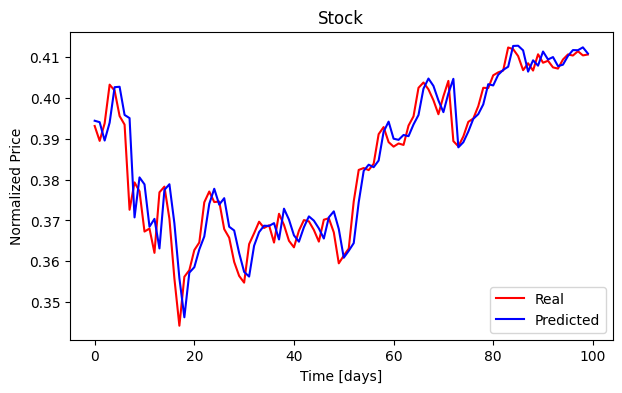

In [28]:
plt.figure(figsize = (7, 4))
plt.plot(norm_test_target[0:100], "red", label= 'Real')   ## Test Target
plt.plot(linear_reg_results["Price_Predictions"][0:100], "blue", label= 'Predicted')  ## Predicted

plt.title('Stock')
plt.xlabel('Time [days]')
plt.ylabel('Normalized Price')
plt.legend(loc= 'best')
plt.show()

In [29]:
print("R2 Metric: ", r2_score(norm_test_target, linear_reg_results["Price_Predictions"]))
print("Price Movement Accuracy: ", accuracy_score(linear_reg_results["Price_Movement_Predictions"], norm_test_target_movement))

R2 Metric:  0.9956195499361895
Price Movement Accuracy:  0.5288326300984529


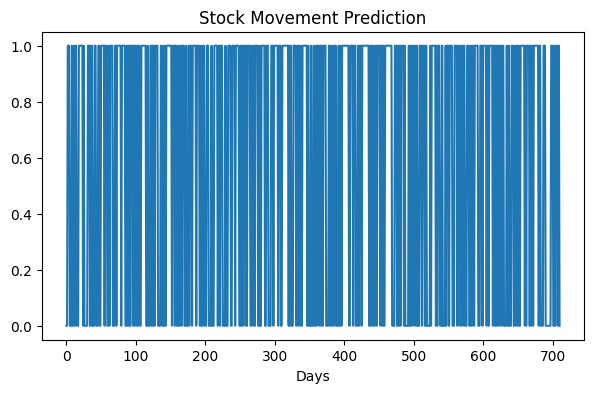

In [30]:
plt.figure(figsize = (7, 4))
plt.title('Stock Movement Prediction')
plt.plot(linear_reg_results["Price_Movement_Predictions"])
plt.xlabel("Days")
plt.show()

### 2. Classification

In [31]:
linear_reg.fit(norm_train_data, train_price_movement)

LinearRegression()

In [32]:
linear_cls_results = pd.DataFrame()
tmp = linear_reg.predict(norm_test_data)
linear_cls_results["Price_Movement_Predictions"] = tmp > 0.5

In [33]:
print("Price Movement Accuracy: ", accuracy_score(linear_cls_results["Price_Movement_Predictions"], norm_test_target_movement))

Price Movement Accuracy:  0.4711673699015471


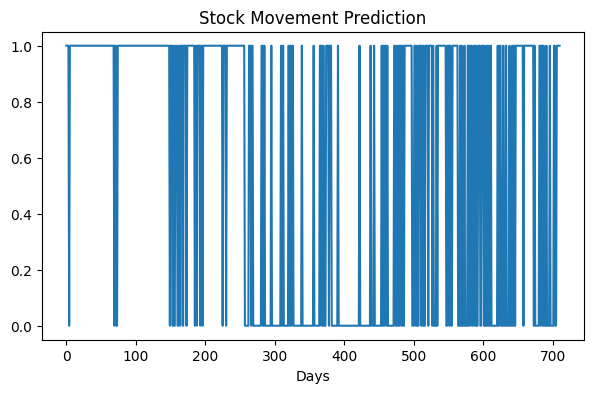

In [34]:
plt.figure(figsize = (7, 4))
plt.title('Stock Movement Prediction')
plt.plot(linear_cls_results)
plt.xlabel("Days")
plt.show()

## Support Vector Machines

### 1. Regression (SVR)

In [35]:
sv_regression = svm.SVR(C=10, degree = 2, kernel= 'sigmoid', tol= 0.1)
sv_regression.fit(norm_train_data, norm_train_target)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=10, degree=2, kernel='sigmoid', tol=0.1)

In [36]:
svr_results = pd.DataFrame()
tmp = sv_regression.predict(norm_test_data)
svr_results["Price_Predictions"] = tmp.reshape(len(tmp))
svr_results["Price_Movement_Predictions"] = svr_results["Price_Predictions"] < svr_results["Price_Predictions"].shift(-1)

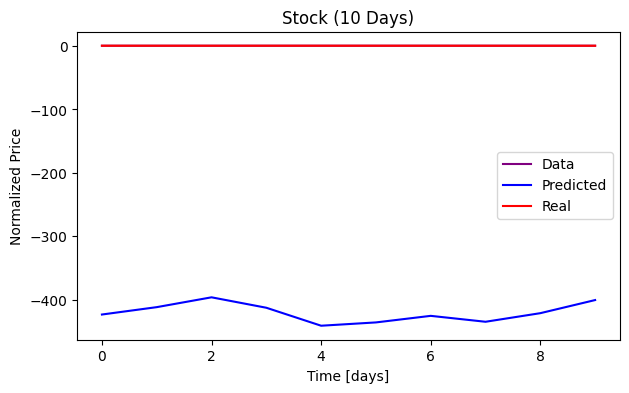

In [37]:
plt.figure(figsize= (7,4))
plt.plot(pd.DataFrame(norm_test_data)[close_column_index][0:10], "purple", label = "Data" )
plt.plot(svr_results["Price_Predictions"][0:10], "blue", label = "Predicted")
plt.plot(norm_test_target[0:10], "red", label = "Real")

plt.title('Stock (10 Days)')
plt.xlabel('Time [days]')
plt.ylabel('Normalized Price')
plt.legend(loc= 'best')
plt.show()

plt.show()

Our

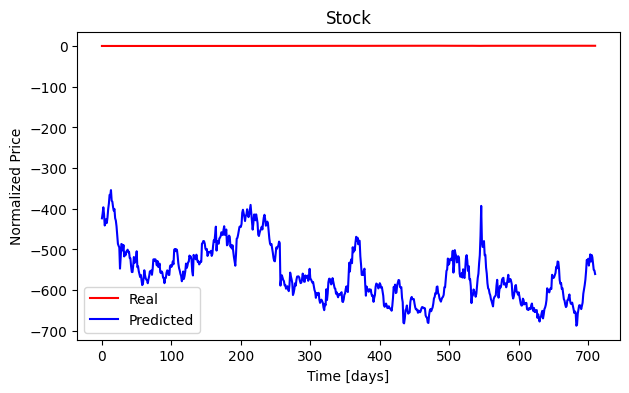

In [38]:
plt.figure(figsize= (7, 4))
plt.plot(norm_test_target, "red", label = "Real")
plt.plot(svr_results["Price_Predictions"], "blue", label= "Predicted")

plt.title('Stock')
plt.xlabel('Time [days]')
plt.ylabel('Normalized Price')
plt.legend(loc= 'best')
plt.show()

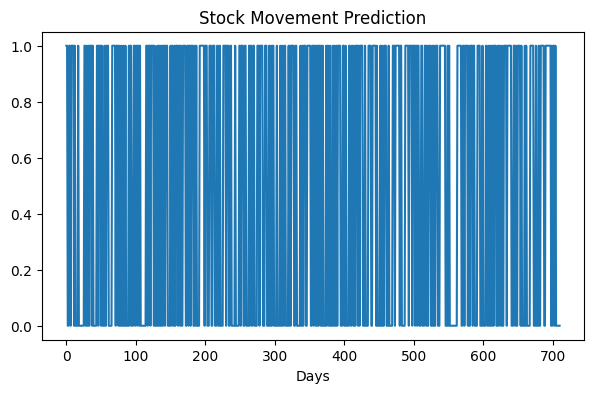

In [39]:
plt.figure(figsize = (7, 4))
plt.plot(svr_results["Price_Movement_Predictions"])
plt.title("Stock Movement Prediction")
plt.xlabel("Days")
plt.show()

In [40]:
print("R2 Metric: ", r2_score(norm_test_target, svr_results["Price_Predictions"]))
print("Price Movement Accuracy: ", accuracy_score(svr_results["Price_Movement_Predictions"], norm_test_target_movement))

R2 Metric:  -7592079.617671651
Price Movement Accuracy:  0.48241912798874825


### 2. Classification (SVC)

In [41]:
sv_classification = svm.SVC(C= 10, gamma = 10, kernel = "rbf")
sv_classification.fit(norm_train_data, train_price_movement)

SVC(C=10, gamma=10)

In [42]:
svc_results = pd.DataFrame()
tmp = sv_classification.predict(norm_test_data)
svc_results["Price_Movement_Predictions"] = tmp.reshape(len(tmp)) > 0.5

In [43]:
print("Price Movement Accuracy: ", accuracy_score(svc_results["Price_Movement_Predictions"], norm_test_target_movement))

Price Movement Accuracy:  0.5513361462728551


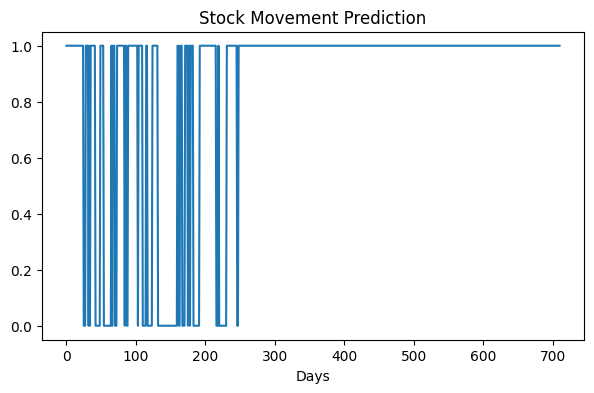

In [44]:
plt.figure(figsize = (7, 4))
plt.plot(svc_results["Price_Movement_Predictions"])
plt.title("Stock Movement Prediction")
plt.xlabel("Days")
plt.show()

## LSTM

In [57]:
def createSequentialModel(input_shape, activation_function):
    model = Sequential()

    model.add(LSTM(
        units=50,
        return_sequences=True,
        input_shape=input_shape)) # Use input_shape argument
    model.add(Dropout(0.2))

    model.add(LSTM(
        units=100,
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=1, activation=activation_function))

    model.compile(loss='mse', optimizer='rmsprop')

    return model

In [58]:
def executeSequentialModel(model, data, target, test_split, epoch):
    min_max_scaler = preprocessing.MinMaxScaler()

    train_data, test_data, train_target, test_target = train_test_split(data, target, test_size = test_split, random_state = 4, shuffle = False)

    fitted_train_data = min_max_scaler.fit_transform(train_data)
    fitted_test_data = min_max_scaler.fit_transform(test_data)


    train_target = list(train_target)
    test_target = list(test_target)

    lstm_train_data = np.reshape(fitted_train_data, (fitted_train_data.shape[0], 1, fitted_train_data.shape[1]))
    lstm_test_data = np.reshape(fitted_test_data, (fitted_test_data.shape[0],1, fitted_test_data.shape[1]))

    print(lstm_train_data.shape)
    print(lstm_test_data.shape)

    lstm_train_target = np.reshape(train_target, (len(train_target), 1))
    lstm_test_target = np.reshape(test_target, (len(test_target), 1))


    model.fit(
    lstm_train_data,
    lstm_train_target,
    batch_size=256,
    epochs= epoch,
    validation_split=0.2, shuffle = False)

    predictions = min_max_scaler.fit_transform(model.predict(lstm_test_data))

    predictions = predictions.reshape(len(predictions))

#     plt.plot(predictions)
#     plt.show()

    return accuracy_score(predictions > 0.5 , test_target, normalize = True), predictions

### 1. Regression

In [59]:
# Reshape the data to be 3D [samples, timesteps, features]
lstm_train_data= norm_train_data.reshape(norm_train_data.shape[0],1, norm_train_data.shape[1])
lstm_test_data= norm_test_data.reshape(norm_test_data.shape[0],1, norm_test_data.shape[1])

# Define the input shape for the model as (timesteps, features)
input_shape = (lstm_train_data.shape[1], lstm_train_data.shape[2])

lstm_model = createSequentialModel(input_shape, "hard_sigmoid")

#lstm_model = createSequentialModel(norm_train_data.shape[1], "hard_sigmoid")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
lstm_train_data= norm_train_data.reshape(norm_train_data.shape[0],1, norm_train_data.shape[1])
lstm_test_data= norm_test_data.reshape(norm_test_data.shape[0],1, norm_test_data.shape[1])

In [61]:
history= lstm_model.fit(
    lstm_train_data,
    norm_train_target,
    batch_size=256,
    epochs= 300,
    validation_split=0.2, shuffle = False)

Epoch 1/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.2191 - val_loss: 0.0625
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2016 - val_loss: 0.0514
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1805 - val_loss: 0.0369
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1509 - val_loss: 0.0210
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1147 - val_loss: 0.0098
Epoch 6/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0751 - val_loss: 0.0102
Epoch 7/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0418 - val_loss: 0.0241
Epoch 8/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0192 - val_loss: 0.0433
Epoch 9/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0089 - val_loss: 0.0575
Epoch 10/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0049 - val_loss: 0.0623
Epoch 11/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0038 - val_loss: 0.0635
Epoch 12/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0032 - val_lo

In [62]:
lstm_reg_results = pd.DataFrame()
tmp = lstm_model.predict(lstm_test_data)
lstm_reg_results["Price_Predictions"] = tmp.reshape(len(tmp))
lstm_reg_results["Price_Movement_Predictions"] = lstm_reg_results["Price_Predictions"] < lstm_reg_results["Price_Predictions"].shift(-1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


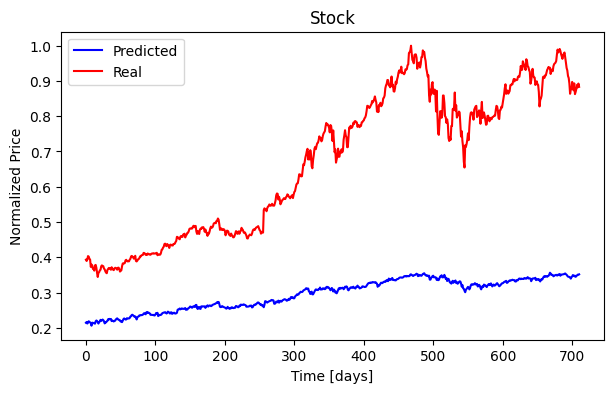

In [63]:
plt.figure(figsize = (7,4))
plt.plot(lstm_reg_results["Price_Predictions"], "blue", label = "Predicted")
plt.plot(norm_test_target,"red", label = "Real")

plt.title('Stock')
plt.xlabel('Time [days]')
plt.ylabel('Normalized Price')
plt.legend(loc= 'best')

plt.show()

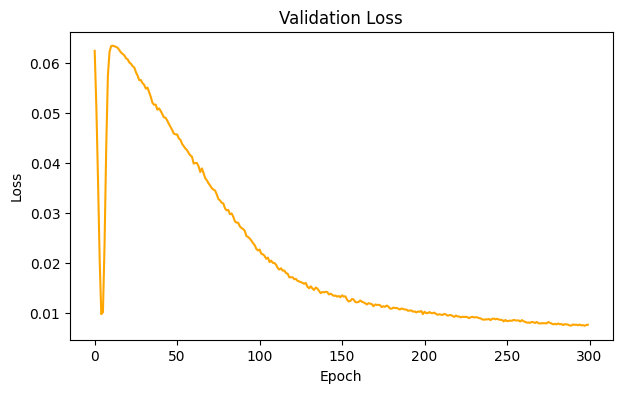

In [64]:
plt.figure(figsize= (7,4))
plt.plot(history.history["val_loss"], "orange")
plt.title("Validation Loss")

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

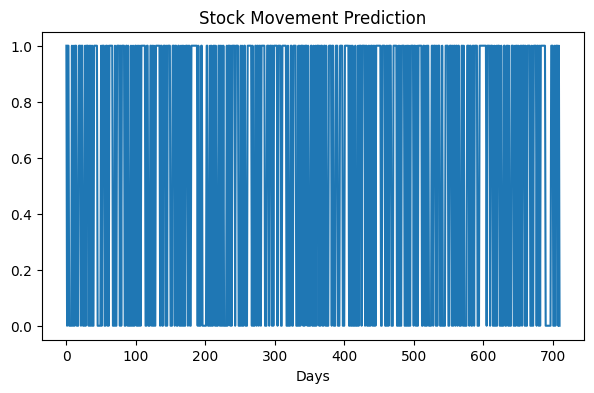

In [65]:
plt.figure(figsize= (7,4))
plt.plot(lstm_reg_results["Price_Movement_Predictions"])
plt.title("Stock Movement Prediction")
plt.xlabel("Days")
plt.show()

In [66]:
print("R2 Metric: ", r2_score(norm_test_target, lstm_reg_results["Price_Predictions"]))
print("Price Movement Accuracy: ", accuracy_score(lstm_reg_results["Price_Movement_Predictions"], norm_test_target_movement))

R2 Metric:  -3.0188839508883802
Price Movement Accuracy:  0.510548523206751


Sometimes it can be around 0.55

### 2. Classification

In [68]:
#lstm_cls_model = createSequentialModel(norm_train_data.shape[1], "hard_sigmoid")
lstm_cls_model = createSequentialModel((1, norm_train_data.shape[1]), "hard_sigmoid")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [69]:
train_price_movement.shape

(2840,)

In [70]:
history= lstm_cls_model.fit(
    lstm_train_data,
    np.asarray(train_price_movement),
    batch_size=256,
    epochs= 40,
    validation_split=0.2, shuffle = False)

Epoch 1/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 2/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2501 - val_loss: 0.2498
Epoch 3/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2498
Epoch 4/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2500 - val_loss: 0.2498
Epoch 5/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2498
Epoch 6/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2498
Epoch 7/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2498
Epoch 8/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2498
Epoch 9/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2501 - val_loss: 0.2498
Epoch 10/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2500 - val_loss: 0.2498
Epoch 11/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2498
Epoch 12/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
E

In [71]:
lstm_cls_results = pd.DataFrame()
tmp = lstm_cls_model.predict(lstm_test_data)
lstm_cls_results["Price_Movement_Predictions"] = tmp.reshape(len(tmp)) > 0.5

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [72]:
print("Price Movement Accuracy: ", accuracy_score(lstm_cls_results["Price_Movement_Predictions"], norm_test_target_movement))

Price Movement Accuracy:  0.559774964838256


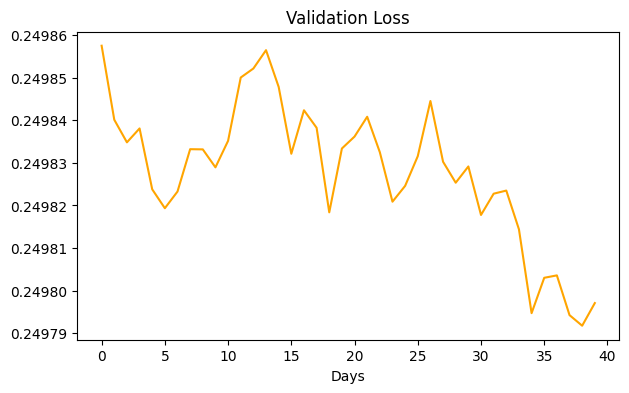

In [73]:
plt.figure(figsize= (7,4))
plt.plot(history.history["val_loss"], "orange")
plt.title("Validation Loss")
plt.xlabel("Days")
plt.show()

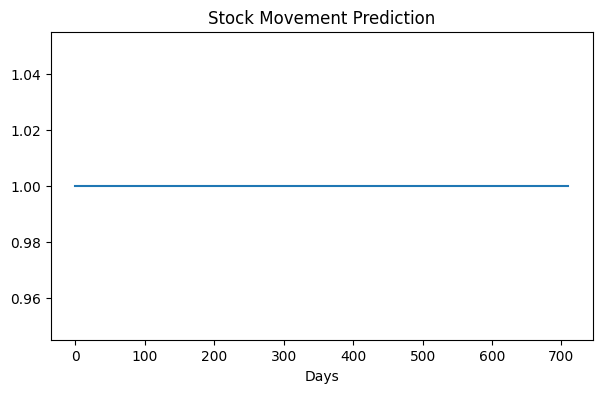

In [78]:
plt.figure(figsize = (7, 4))
plt.plot(lstm_cls_results["Price_Movement_Predictions"])
plt.title("Stock Movement Prediction")
plt.xlabel("Days")

plt.show()

### 3. Accuracy Based Selection
Our motivation is, we select only features that increase accuracy.

In [76]:
max_accuracy = 0
column_names = mydata.columns
added_columns = list()
tmp_columns = list()
test_split = 0.2
epoch = 10
for i in column_names:
    tmp_columns = added_columns.copy()
    tmp_columns.append(i)
    model = createSequentialModel((1, len(tmp_columns)), "hard_sigmoid")
    print("Columns: ", tmp_columns)
    accuracy, predictions = executeSequentialModel(model, mydata[tmp_columns], price_movement, test_split, epoch)
    print("Current Accuracy: ", accuracy)
    if accuracy > max_accuracy:
        added_columns.append(i)
        print("Max Accuracy: ", max_accuracy)
        max_accuracy = accuracy

    else : print("Max Accuracy: ", max_accuracy)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Columns:  ['Open']
(2840, 1, 1)
(711, 1, 1)
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 0.2500 - val_loss: 0.2501
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Current Accuracy:  0.4936708860759494
Max Accuracy:  0
Columns:  ['Open', 'High']
(28

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Current Accuracy:  0.49226441631504925
Max Accuracy:  0.4936708860759494
Columns:  ['Open', 'Low']
(2840, 1, 2)
(711, 1, 2)
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Current Accuracy:  0.5021097046413502
Max Accuracy:  0.4936708860759494
Columns:  ['Open', 'Low', 'Close']
(2840, 1, 3)
(711, 1, 3)
Epoch 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Current Accuracy:  0.5021097046413502
Max Accuracy:  0.5021097046413502
Columns:  ['Open', 'Low', 'Volume']
(2840, 1, 3)
(711, 1, 3)
Epoch 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Current Accuracy:  0.49929676511954996
Max Accuracy:  0.5021097046413502
Columns:  ['Open', 'Low', 'Dividends']
(2840, 1, 3)
(711, 1, 3)
Epo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Current Accuracy:  0.4964838255977497
Max Accuracy:  0.5021097046413502
Columns:  ['Open', 'Low', 'Stock Splits']
(2840, 1, 3)
(711, 1, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Current Accuracy:  0.4908579465541491
Max Accuracy:  0.5021097046413502
Columns:  ['Open', 'Low', 'Gain']
(2840, 1, 3)
(711, 1, 3)
Epoch 1/1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Current Accuracy:  0.530239099859353
Max Accuracy:  0.5021097046413502
Columns:  ['Open', 'Low', 'Gain', 'Loss']
(2840, 1, 4)
(711, 1, 4)
Ep

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Current Accuracy:  0.549929676511955
Max Accuracy:  0.530239099859353
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Avg_Gain']
(2840, 1, 5)
(7

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Current Accuracy:  0.47257383966244726
Max Accuracy:  0.549929676511955
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Avg_Loss']
(2840, 1, 5)
(

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Current Accuracy:  0.48945147679324896
Max Accuracy:  0.549929676511955
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'EMA']
(2840, 1, 5)
(711, 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Current Accuracy:  0.48523206751054854
Max Accuracy:  0.549929676511955
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'MACD']
(2840, 1, 5)
(711,

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.2500 - val_loss: 0.2501
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2500 - val_loss: 0.2501
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2500 - val_loss: 0.2500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Current Accuracy:  0.47960618846694797
Max Accuracy:  0.549929676511955
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Bollinger_Upper']
(2840, 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Current Accuracy:  0.4669479606188467
Max Accuracy:  0.549929676511955
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Bollinger_Lower']
(2840, 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Current Accuracy:  0.4964838255977497
Max Accuracy:  0.549929676511955
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'ROC']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


(2840, 1, 5)
(711, 1, 5)
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2500 - val_loss: 0.2500
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step
Current Accuracy:  0.44022503516174405
Max Accuracy:  0.549929676511955
Columns:  ['Open', 'Low', 'Gain'

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Current Accuracy:  0.5485232067510548
Max Accuracy:  0.549929676511955
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Usd_Eur_Close']
(2840, 1, 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Current Accuracy:  0.4908579465541491
Max Accuracy:  0.549929676511955
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Usd_Chf_Close']
(2840, 1, 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Current Accuracy:  0.4472573839662447
Max Accuracy:  0.549929676511955
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Usd_Gbp_Close']
(2840, 1, 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Current Accuracy:  0.4613220815752461
Max Accuracy:  0.549929676511955
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Usd_Jpy_Close']
(2840, 1,

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Current Accuracy:  0.510548523206751
Max Accuracy:  0.549929676511955
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Usd_Cad_Close']
(2840, 1, 5

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Current Accuracy:  0.4880450070323488
Max Accuracy:  0.549929676511955
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Usd_Inf_Close']
(2840, 1, 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Current Accuracy:  0.5625879043600562
Max Accuracy:  0.549929676511955
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Usd_Rub_Close', 'Usd_Try_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.2500 - val_loss: 0.2501
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2500 - val_loss: 0.2500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Current Accuracy:  0.510548523206751
Max Accuracy:  0.5625879043600562
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Usd_Rub_Close', 'IRX_Close

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Current Accuracy:  0.5077355836849508
Max Accuracy:  0.5625879043600562
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Usd_Rub_Close', 'JPM_Clos

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Current Accuracy:  0.5218002812939522
Max Accuracy:  0.5625879043600562
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Usd_Rub_Close', 'Citigro

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.2500 - val_loss: 0.2501
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Current Accuracy:  0.4669479606188467
Max Accuracy:  0.5625879043600562
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Usd_Rub_Close', 'WFC_Clos

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Current Accuracy:  0.4880450070323488
Max Accuracy:  0.5625879043600562
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Usd_Rub_Close', 'NASDAQ_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.2500 - val_loss: 0.2500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Current Accuracy:  0.4711673699015471
Max Accuracy:  0.5625879043600562
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Usd_Rub_Close', 'SP_500_C

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


(2840, 1, 6)
(711, 1, 6)
Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2500 - val_loss: 0.2500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Current Accuracy:  0.4472573839662447
Max Accuracy:  0.5625879043600562
Columns:  ['Open', 'Low', 'Gain'

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2500 - val_loss: 0.2500
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2500 - val_loss: 0.2500
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Current Accuracy:  0.45569620253164556
Max Accuracy:  0.5625879043600562
Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Usd_Rub_Close', 'Google_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2500 - val_loss: 0.2499
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2500 - val_loss: 0.2499
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Current Accuracy:  0.45147679324894513
Max Accuracy:  0.5625879043600562


In [77]:
print("Added Columns: ", added_columns)
print("Max Accuracy: ", max_accuracy)

Added Columns:  ['Open', 'Low', 'Gain', 'Loss', 'Usd_Rub_Close']
Max Accuracy:  0.5625879043600562


These selected features may change every time. But now, we can maximize our model's accuracy with these features.